In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from lightning.pytorch.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from lightning.pytorch.loggers import CSVLogger
from mango import scheduler, Tuner
from sklearn.metrics import r2_score, root_mean_squared_error
from torch.nn import (
    BatchNorm1d,
    L1Loss,
    MSELoss,
    Linear,
    ModuleList,
    ReLU,
    Sequential,
)
from torch_geometric.nn import (
    GINEConv,
    GPSConv,
    GraphNorm,
    SAGPooling,
    SetTransformerAggregation,
)
from rdkit import Chem
from sklearn.feature_selection import r_regression

c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext kedro.ipython

[08/01/24 12:18:05] INFO     Registered line magic '%reload_kedro'                                   ]8;id=677071;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=209410;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\ipython\__init__.py#58\58]8;;\

                    INFO     Registered line magic '%load_node'                                      ]8;id=635135;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=893083;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\ipython\__init__.py#60\60]8;;\

                    INFO     Resolved project path as:                                              ]8;id=581127;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=693300;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\ipython\__init__.py#171\171]8;;\
                             c:\Users\01121272\Desktop\Projects\gnn-mp-model.                                      
                             To set a different path, run '%reload_kedro <project_root>'                           

[08/01/24 12:18:08] INFO     Registering new custom resolver: 'km.random_name'                    ]8;id=674848;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro_mlflow\framework\hooks\mlflow_hook.py\mlflow_hook.py]8;;\:]8;id=869908;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro_mlflow\framework\hooks\mlflow_hook.py#65\65]8;;\

                    INFO     The 'tracking_uri' key in mlflow.yml is relative            ]8;id=765512;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro_mlflow\config\kedro_mlflow_config.py\kedro_mlflow_config.py]8;;\:]8;id=550357;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro_mlflow\config\kedro_mlflow_config.py#260\260]8;;\
                             ('server.mlflow_(tracking|registry)_uri = mlruns'). It is                             
                             converted to a valid uri:                                                             
                             'file:///C:/Users/01121272/Desktop/Projects/gnn-mp-model/ml                           
                             runs'                                                                                 

[08/01/24 12:18:09] INFO     Kedro project GNN_MP_model                                             ]8;id=897617;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=315605;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\ipython\__init__.py#141\141]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=840625;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=288582;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\ipython\__init__.py#142\142]8;;\
                             'pipelines'                                                                           

[08/01/24 12:18:10] INFO     Registered line magic 'run_viz'                                        ]8;id=359858;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=958154;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\ipython\__init__.py#148\148]8;;\

In [3]:
merged_df = catalog.load("merged_database")
train_dataloader = catalog.load("random_train_dataloader")
test_dataloader = catalog.load("random_test_dataloader")
predict_dataloader = catalog.load('predict_dataloader')
strain_dataloader = catalog.load("sys_train_dataloader")
stest_dataloader = catalog.load("sys_test_dataloader")

                    INFO     Loading data from merged_database (CSVDataset)...                  ]8;id=976087;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=938787;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

                    INFO     Loading data from random_train_dataloader (GraphDataset)...        ]8;id=857757;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=566822;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

[08/01/24 12:18:11] INFO     Loading data from random_test_dataloader (GraphDataset)...         ]8;id=965642;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=215670;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

                    INFO     Loading data from predict_dataloader (GraphDataset)...             ]8;id=861680;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=868694;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

[08/01/24 12:18:12] INFO     Loading data from sys_train_dataloader (GraphDataset)...           ]8;id=285205;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=293070;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

[08/01/24 12:18:13] INFO     Loading data from sys_test_dataloader (GraphDataset)...            ]8;id=119355;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=768616;file://c:\Users\01121272\Desktop\Projects\gnn-mp-model\.venv\Lib\site-packages\kedro\io\data_catalog.py#508\508]8;;\

In [4]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_size: int, dense_size: int, num_layers:int, pooling: bool):  # noqa: PLR0913
        # Loading params
        super().__init__()
        self.num_layers = num_layers
        self.pooling = pooling
        node_dim = 9
        edge_dim = 4
        pe_dim = 8
        # gf_dim = 6 # not used
        pool_rate = 0.75
        # Initial embeddings
        self.node_emb = Linear(pe_dim+node_dim, hidden_size)
        self.pe_lin = Linear(30, pe_dim)
        self.pe_norm = BatchNorm1d(30)
        self.edge_emb = Linear(edge_dim, hidden_size)
        self.aggr = SetTransformerAggregation(hidden_size)
        # PNA
        self.gps_list = ModuleList([])
        self.gn_list = ModuleList([])
        self.aggr_list = ModuleList([])
        self.pool_list = ModuleList([])
        # Initial layers
        for _ in range(self.num_layers):
            nn = Sequential(
                Linear(hidden_size, hidden_size),
                ReLU(),
                Linear(hidden_size, hidden_size))
            self.gps_list.append(GPSConv(hidden_size, GINEConv(nn, edge_dim=hidden_size), heads=4, dropout=0.2))
            self.gn_list.append(GraphNorm(hidden_size))
            self.aggr_list.append(SetTransformerAggregation(hidden_size))
            self.pool_list.append(SAGPooling(hidden_size, pool_rate))

        # Linear layers
        self.linear1 = Linear(hidden_size, dense_size)
        self.linear2 = Linear(dense_size, int(dense_size / 2))
        self.linear3 = Linear(int(dense_size / 2), int(dense_size / 4))
        self.linear4 = Linear(int(dense_size / 4), 1)

    def forward(self, x, pe, edge_attr, edge_index, batch_index, gf):  # noqa: PLR0913
        # Initial embeddings
        x_pe = self.pe_norm(pe)
        x = torch.cat((x, self.pe_lin(x_pe)), 1)
        x = self.node_emb(x)
        edge_attr = self.edge_emb(edge_attr)
        global_representation = []
        global_representation.append(self.aggr(x, batch_index))
        ### Internal convolutions
        for i in range(self.num_layers):
            x = self.gps_list[i](x, edge_index, batch_index, edge_attr=edge_attr)
            x = self.gn_list[i](x, batch_index)
            if self.pooling is True:
                x, edge_index, edge_attr, batch_index, _, _ = self.pool_list[i](
                x, edge_index, edge_attr, batch_index
            )
            global_representation.append(self.aggr_list[i](x, batch_index))
        ### Output block
        x = sum(global_representation)
        # x = torch.cat((x, gf), 1)
        x = torch.relu(self.linear1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = torch.relu(self.linear2(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = torch.relu(self.linear3(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.linear4(x)
        return x

In [5]:
import lightning as L


class GNN_L(L.LightningModule):
    def __init__(self, params):
        super().__init__()
        self.model = GNN(params["hidden_size"], params["dense_size"], params["num_layers"], params["pooling"])
        self.lr = params["lr"]
        self.weight_decay = params["weight_decay"]
        self.gamma = params["gamma"]
        self.loss_fn = L1Loss()
        self.save_hyperparameters(params)

    def forward(self, x, pe, edge_attr, edge_index, batch_index, gf):  # noqa: PLR0913
        return self.model(x.float(), pe, edge_attr.float(), edge_index, batch_index, gf)

    def training_step(self, batch, batch_index):
        preds = self(batch.x.float(), batch.pe, batch.edge_attr.float(), batch.edge_index, batch.batch, batch.gf.float()).squeeze()
        target = batch.y.float()
        loss = self.loss_fn(preds, target)
        r2 = r2_score(target.numpy(), preds.detach().numpy())
        rmse = root_mean_squared_error(target.numpy(), preds.detach().numpy())
        self.log("r2", r2)
        self.log("rmse", rmse)
        self.log("mae", loss)
        return loss

    def validation_step(self, batch, batch_index):
        preds = self(batch.x.float(), batch.pe, batch.edge_attr.float(), batch.edge_index, batch.batch, batch.gf.float()).squeeze()
        target = batch.y.float()
        val_loss = self.loss_fn(preds, target)
        val_r2 = r2_score(target.numpy(), preds.detach().numpy())
        val_rmse = root_mean_squared_error(target.numpy(), preds.detach().numpy())
        self.log("val_mae", val_loss)
        self.log("val_r2", val_r2)
        self.log("val_rmse", val_rmse)
    def test_step(self, batch, batch_index, dataloader_idx=0):
        preds = self(batch.x.float(), batch.pe, batch.edge_attr.float(), batch.edge_index, batch.batch, batch.gf.float()).squeeze()
        target = batch.y.float()
        test_mae = self.loss_fn(preds, target)
        test_r2 = r2_score(target.numpy(), preds.detach().numpy())
        self.log("test_mae", test_mae)
        self.log("test_r2", test_r2)
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        preds = [self(batch.x.float(), batch.pe, batch.edge_attr.float(), batch.edge_index, batch.batch, batch.gf.float()).squeeze(), batch.smiles, batch.y]
        return preds
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr,
            weight_decay = self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(  # noqa: F811
            optimizer, gamma=self.gamma
        )
        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]

In [6]:
# Trainer

def train_model(params):
    filename = "GPS_Main_Model_ensemble"
    L.seed_everything(47)
    model = GNN_L(params)
    early_stopping = EarlyStopping("val_mae", patience=40, mode="min", strict=False)
    lr_monitor = LearningRateMonitor(logging_interval="epoch")
    checkpoint_callback = ModelCheckpoint(filename="{epoch}-{val_mae:.2f}-{val_rmse:.2f}",
                                          monitor="val_mae",
                                          save_top_k=2,
                                          mode="min")

    logger = CSVLogger(save_dir="logs", name=filename)
    trainer = L.Trainer(
        max_epochs=40,
        callbacks=[early_stopping, lr_monitor, checkpoint_callback],
        log_every_n_steps=20,
        logger=logger,
        deterministic=True,
        accumulate_grad_batches=1
    )
    # Model pretraining
    trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    return model, trainer

In [ ]:
params = {
    "lr": 0.001,
    "weight_decay": 1e-05,
    "gamma": 0.95,
    "hidden_size": 32,
    "dense_size": 64,
    "num_layers": 5,
    "pooling": False,
    "gf_incl": False,
    "random_state": 47
}
model, trainer = train_model(params)

In [9]:
def predict_on_df(model, predict_dataloader):
    preds = []
    for batch in predict_dataloader:
        model.eval()
        result = model.predict_step(batch, batch.batch)
        preds.append(result)
    preds_list = []
    target_list = []
    smiles_list = []
    for item in preds:
        preds_list.append(float(item[0]))
        target_list.append(float(item[2]))
        smiles_list.append(item[1][0])
    df = pd.DataFrame(data=[preds_list, target_list, smiles_list]).transpose()
    df.columns = ["preds", "target", "smiles"]
    df["error"] = abs(df["preds"]- df["target"]).astype(float)
    return df

def add_cation_anion_smiles(df):
    cation_list = []
    anion_list = []
    for _, row in df.iterrows():
        smiles_list = row["smiles"].split(".")
        if "+" in smiles_list[0]:
            cation_list.append(smiles_list[0])
            anion_list.append(smiles_list[1])
        else:
            cation_list.append(smiles_list[1])
            anion_list.append(smiles_list[0])

    df["cation_smiles"] = cation_list
    df["anion_smiles"] = anion_list
    return df

In [ ]:
def print_metrics(model):
    loaders = [predict_dataloader]
    L.seed_everything(42)
    for loader in loaders:
        df = predict_on_df(model, loader)
        mae = df["error"].mean()
        r2 = r2_score(df["target"], df["preds"])
        results = {
            "mae": mae,
            "r2": r2
        }
        print(results)

In [22]:
model_ckpt = GNN_L.load_from_checkpoint("model_base.ckpt")

In [33]:
df

,preds,target,smiles,error,ens_preds,ens_error
0,148.178467,85.0,O=S(=O)([O-])O.c1c[nH+]c[nH]1,63.178467,128.019174,43.019174
1,119.084305,188.0,CS(=O)(=O)[O-].c1c[nH+]c[nH]1,68.915695,105.190880,82.80912
2,116.022095,122.900002,O=S(=O)(O)C(F)(F)F.c1c[nH+]c[nH]1,6.877907,113.471214,9.428787
3,87.695374,73.0,O=S(=O)([N-]S(=O)(=O)C(F)(F)F)C(F)(F)F.c1c[nH+...,14.695374,89.675325,16.675325
4,145.290253,131.199997,F[B-](F)(F)F.c1c[nH+]c[nH]1,14.090256,116.373698,14.826299
...,...,...,...,...,...,...
2775,66.270844,72.949997,C[N+](C)(C)CCO.O=[N+]([O-])[O-],6.679153,62.525629,10.424368
2776,43.413563,43.75,CC(=O)[O-].CCCC[NH3+],0.336437,51.797799,8.047799
2777,83.193886,75.849998,CC(=O)[O-].CN1CCCN2CCC[NH+]=C12,7.343887,68.735954,7.114044
2778,8.348602,45.450001,CCCC[N+]1(C)CCCC1.O=S(=O)([O-])C(F)(F)C(F)F,37.101398,18.863777,26.586223


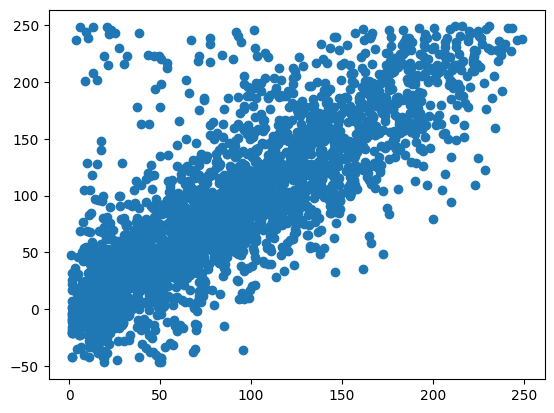

In [34]:
plt.scatter(df["preds"], df["target"])